Importation des bibliothèques

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [5]:
import os

# Charger les données
file_path = "C:\\Users\\ADMIN\\Desktop\\air_paradise_chatbot\\data\\final\\dataset_final.csv"
if os.path.exists(file_path):
	df = pd.read_csv(file_path)
	
	# Vérification des données
	print(df.info())
	print(df.head())
else:
	print(f"[ERROR] Le fichier spécifié n'existe pas : {file_path}")
	df = None  # Assurez-vous que df est défini même si le fichier est manquant

if df is not None:
	# Conversion des booléens en int (nécessaire pour les modèles)
	df["DEPARTURE_PERIOD_matin"] = df["DEPARTURE_PERIOD_matin"].astype(int)
	df["DEPARTURE_PERIOD_soir"] = df["DEPARTURE_PERIOD_soir"].astype(int)

	# Séparation des features (X) et de la cible (y)
	X = df.drop(columns=["PRICE_USD"])
	y = df["PRICE_USD"]
else:
	print("[ERROR] Impossible de continuer car les données n'ont pas été chargées.")
	X, y = None, None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3427300 entries, 0 to 3427299
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   DISTANCE                int64  
 1   SCHEDULED_TIME          float64
 2   MONTH                   int64  
 3   DAY_OF_WEEK             int64  
 4   PRICE_USD               float64
 5   col_0                   int64  
 6   col_1                   int64  
 7   col_2                   int64  
 8   col_3                   int64  
 9   col_4                   int64  
 10  col_5                   int64  
 11  col_6                   int64  
 12  col_7                   int64  
 13  DEPARTURE_PERIOD_matin  bool   
 14  DEPARTURE_PERIOD_soir   bool   
dtypes: bool(2), float64(2), int64(11)
memory usage: 346.5 MB
None
   DISTANCE  SCHEDULED_TIME  MONTH  DAY_OF_WEEK  PRICE_USD  col_0  col_1  \
0      1448           205.0      1            4     523.85      0      0   
1      2296           286.0      1     

Séparation train/test et normalisation

In [6]:
# Séparation en jeu d'entraînement et test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation uniquement pour la Régression Linéaire
scaler = StandardScaler()
cols_to_scale = ["DISTANCE", "SCHEDULED_TIME", "MONTH", "DAY_OF_WEEK"]
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

Entraînement des modèles

In [7]:
models = {
    "Régression Linéaire": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n[INFO] Entraînement du modèle: {name}")
    
    # Sélectionner les données normalisées pour la régression linéaire
    if name == "Régression Linéaire":
        model.fit(X_train_scaled, y_train)
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
    
    # Évaluation sur train et test
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    
    results[name] = {
        "Train MAE": train_mae, "Test MAE": test_mae,
        "Train RMSE": train_rmse, "Test RMSE": test_rmse,
        "Train R2": train_r2, "Test R2": test_r2
    }
    
    print(f"Train - MAE: {train_mae:.2f}, RMSE: {train_rmse:.2f}, R²: {train_r2:.2f}")
    print(f"Test  - MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, R²: {test_r2:.2f}")


[INFO] Entraînement du modèle: Régression Linéaire
Train - MAE: 37.51, RMSE: 57.72, R²: 0.89
Test  - MAE: 37.46, RMSE: 57.75, R²: 0.89

[INFO] Entraînement du modèle: Random Forest
Train - MAE: 23.62, RMSE: 36.81, R²: 0.96
Test  - MAE: 32.08, RMSE: 50.24, R²: 0.92

[INFO] Entraînement du modèle: XGBoost
Train - MAE: 29.51, RMSE: 45.50, R²: 0.93
Test  - MAE: 29.54, RMSE: 45.68, R²: 0.93


Comparaison et visualisation des résultats

                     Train MAE   Test MAE  Train RMSE  Test RMSE  Train R2  \
Régression Linéaire  37.514953  37.456985   57.724772  57.749716  0.894380   
Random Forest        23.615297  32.079736   36.810995  50.243810  0.957049   
XGBoost              29.511761  29.540723   45.497796  45.683474  0.934385   

                      Test R2  
Régression Linéaire  0.894492  
Random Forest        0.920136  
XGBoost              0.933976  


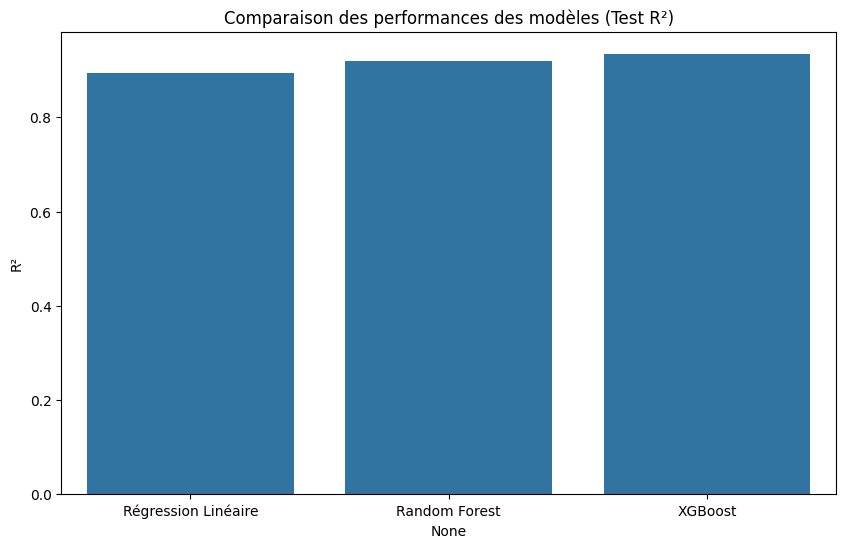

In [8]:
df_results = pd.DataFrame(results).T
print(df_results)

# Visualisation des performances
plt.figure(figsize=(10, 6))
sns.barplot(data=df_results, x=df_results.index, y="Test R2")
plt.title("Comparaison des performances des modèles (Test R²)")
plt.ylabel("R²")
plt.show()

Visualisation des erreurs

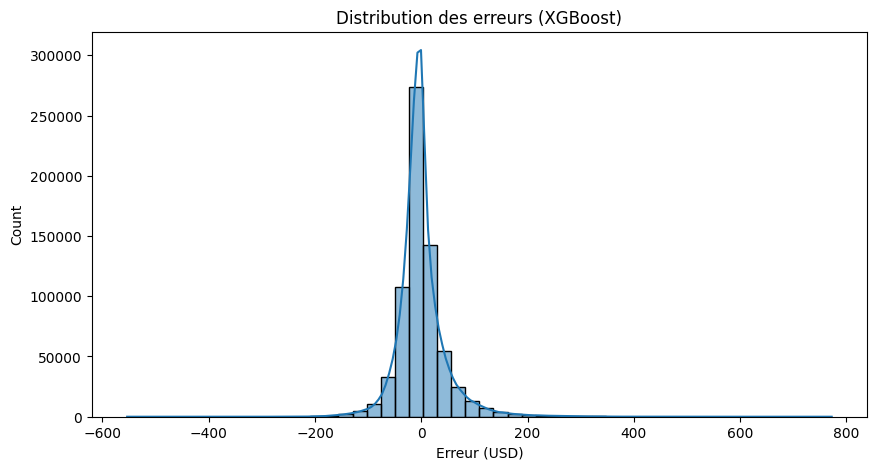

In [9]:
best_model_name = max(results, key=lambda k: results[k]['Test R2'])
best_model = models[best_model_name]
y_test_pred_best = best_model.predict(X_test)

# Histogramme des erreurs
errors = y_test - y_test_pred_best
plt.figure(figsize=(10, 5))
sns.histplot(errors, bins=50, kde=True)
plt.title(f"Distribution des erreurs ({best_model_name})")
plt.xlabel("Erreur (USD)")
plt.show()

Sauvegarde du modele

In [10]:
# Sauvegarde du modèle entraîné
import joblib
model_path = "C:\\Users\\ADMIN\\Desktop\\air_paradise_chatbot\\models\\best_flight_price_model.pkl"
joblib.dump(model, model_path)

print(f"[INFO] Modèle XGBoost sauvegardé sous : {model_path}")

[INFO] Modèle XGBoost sauvegardé sous : C:\Users\ADMIN\Desktop\air_paradise_chatbot\models\best_flight_price_model.pkl


Charger le modèle et prédire les prix

In [12]:
model = joblib.load(model_path)

# Charger les nouvelles données à prédire
df = pd.read_csv("C:\\Users\\ADMIN\\Desktop\\air_paradise_chatbot\\data\\final\\dataset_final.csv")

# Supprimer "PRICE_USD" pour éviter la fuite de données
X_to_predict = df.drop(columns=["PRICE_USD"], errors="ignore")

# Prédire les prix des vols
predictions = model.predict(X_to_predict)

# Ajouter les prédictions au dataset
df["PREDICTED_PRICE_USD"] = predictions

# Afficher un aperçu des résultats
print(df[["DISTANCE", "SCHEDULED_TIME", "MONTH", "DAY_OF_WEEK", "PREDICTED_PRICE_USD"]].head())

   DISTANCE  SCHEDULED_TIME  MONTH  DAY_OF_WEEK  PREDICTED_PRICE_USD
0      1448           205.0      1            4           452.066467
1      2296           286.0      1            4           742.170776
2      1448           235.0      1            4           546.478149
3      2125           273.0      1            4           728.523193
4      1448           204.0      1            4           447.028748


In [ ]:
# Sauvegarder les prédictions
predictions_path = "C:\\Users\\ADMIN\\Desktop\\air_paradise_chatbot\\data\\final\\final_dataset_with_predictions.csv"
df.to_csv(predictions_path, index=False)

In [13]:
print(df["PREDICTED_PRICE_USD"].describe())

count    3.427300e+06
mean     2.477064e+02
std      1.714928e+02
min      4.137475e+01
25%      1.302117e+02
50%      1.991857e+02
75%      3.102405e+02
max      2.174795e+03
Name: PREDICTED_PRICE_USD, dtype: float64


Distribution des prix predits

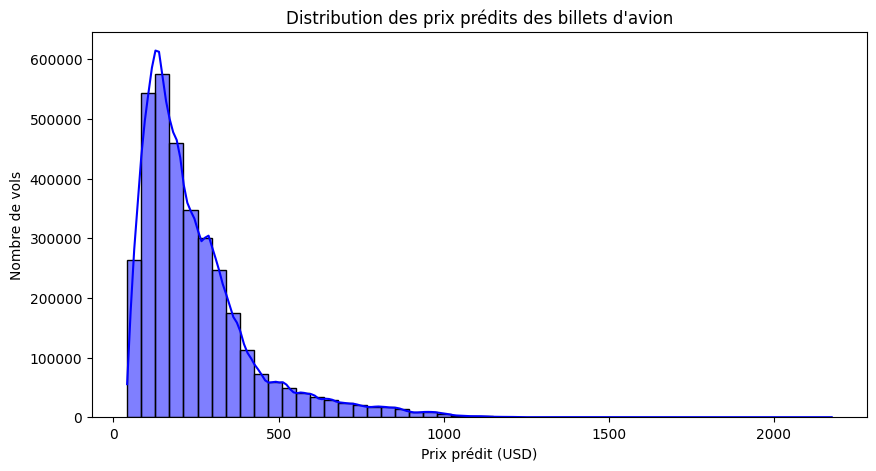

In [14]:
# Visualisation de la distribution des prix prédits
plt.figure(figsize=(10, 5))
sns.histplot(df["PREDICTED_PRICE_USD"], bins=50, kde=True, color="blue")
plt.xlabel("Prix prédit (USD)")
plt.ylabel("Nombre de vols")
plt.title("Distribution des prix prédits des billets d'avion")
plt.show()

comparaison des prix predits avec les prix reels

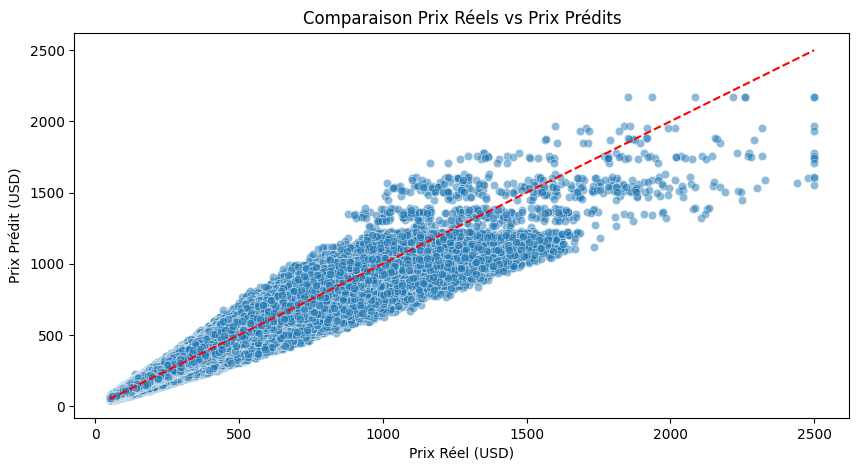

In [15]:
if "PRICE_USD" in df.columns:
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=df["PRICE_USD"], y=df["PREDICTED_PRICE_USD"], alpha=0.5)
    plt.plot([df["PRICE_USD"].min(), df["PRICE_USD"].max()], 
            [df["PRICE_USD"].min(), df["PRICE_USD"].max()], '--', color='red')
    plt.xlabel("Prix Réel (USD)")
    plt.ylabel("Prix Prédit (USD)")
    plt.title("Comparaison Prix Réels vs Prix Prédits")
    plt.show()

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calcul des erreurs sur le dataset prédit
mae = mean_absolute_error(df["PRICE_USD"], df["PREDICTED_PRICE_USD"])
rmse = np.sqrt(mean_squared_error(df["PRICE_USD"], df["PREDICTED_PRICE_USD"]))
r2 = r2_score(df["PRICE_USD"], df["PREDICTED_PRICE_USD"])

print(f"📊 Performance actuelle :\n - MAE : {mae:.2f} $\n - RMSE : {rmse:.2f} $\n - R² : {r2:.4f}")


📊 Performance actuelle :
 - MAE : 29.52 $
 - RMSE : 45.53 $
 - R² : 0.9343


c:\Users\ADMIN\Desktop\air_paradise_chatbot\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


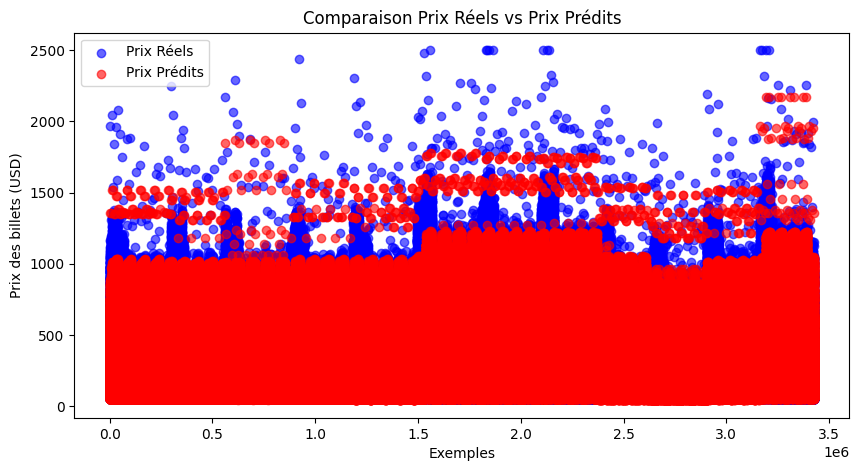

In [17]:
import matplotlib.pyplot as plt

# Charger les données réelles
y_real = df["PRICE_USD"][:len(predictions)]  # Assure que les tailles correspondent

# Tracer la comparaison
plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_real)), y_real, color="blue", label="Prix Réels", alpha=0.6)
plt.scatter(range(len(predictions)), predictions, color="red", label="Prix Prédits", alpha=0.6)
plt.xlabel("Exemples")
plt.ylabel("Prix des billets (USD)")
plt.title("Comparaison Prix Réels vs Prix Prédits")
plt.legend()
plt.show()

Ajouter les prix predits à notre dataset_cleaned_standard

verififions le taille

In [31]:
print(len(df["PREDICTED_PRICE_USD"]))
print

3427300


<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [33]:
df_cleaned_standard = pd.read_csv("C:\\Users\\ADMIN\\Desktop\\air_paradise_chatbot\\data\\cleaned\\dataset_cleaned_standard.csv")
print(len(df_cleaned_standard))

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_46708\1922159394.py:1: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cleaned_standard = pd.read_csv("C:\\Users\\ADMIN\\Desktop\\air_paradise_chatbot\\data\\cleaned\\dataset_cleaned_standard.csv")


3427300


Ajout de la colonne au Dataframe

In [35]:
# Ajouter la colonne des prédictions depuis un autre DataFrame (ici 'df')
df_cleaned_standard["PREDICTED_PRICE_USD"] = df["PREDICTED_PRICE_USD"]

# Sauvegarder si besoin
df_cleaned_standard.to_csv("C:\\Users\\ADMIN\\Desktop\\air_paradise_chatbot\\data\\final\\dataset_cleaned_standard_with_predictions.csv", index=False)

Creation du fichier final pour la realisation du chatbot

In [30]:
df_cleaned_standard_path = "C:\\Users\\ADMIN\\Desktop\\air_paradise_chatbot\\data\\final\\cleaned_standard_with_predictions.csv"
df_cleaned_standard.to_csv(df_cleaned_standard_path, index=False)
print(f"[INFO] Dataset cleaned avec les prédictions sauvegardé sous : {df_cleaned_standard_path}")

[INFO] Dataset cleaned avec les prédictions sauvegardé sous : C:\Users\ADMIN\Desktop\air_paradise_chatbot\data\final\cleaned_standard_with_predictions.csv
